# Dependências

In [ ]:
!pip install diffusers transformers accelerate xformers safetensors pillow opencv-python matplotlib pycocotools
!pip install groundingdino-py
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8oqv3e5q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8oqv3e5q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


# Funções auxiliares

## Imagem

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

def upload_image():
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return Image.open(io.BytesIO(uploaded[filename]))

def save_image(img, path):
    img.save(path)

def show_image(img, title="Image", figsize=(6,6), cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def overlay_mask(image, mask, color=(255,0,0), alpha=0.5):
  image = image.convert("RGBA")
  mask = mask.convert("L")
  overlay = Image.new("RGBA", image.size, color + (0,))
  overlay.putalpha(mask.point(lambda p: int(p*alpha)))
  return Image.alpha_composite(image, overlay)

## Segmentação

In [ ]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import numpy as np
import urllib.request

def load_segmentation_model(device="cuda"):
    feature_extractor = SegformerFeatureExtractor.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512"
    )
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512"
    ).to(device)
    model.eval()
    return feature_extractor, model

def get_masks(image: Image.Image, feature_extractor, model, device="cuda"):
    model.to(device)
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False
        )
        masks = torch.argmax(upsampled_logits, dim=1)[0].cpu().numpy()
    num_classes = logits.shape[1]
    class_masks = {}
    for cls in range(num_classes):
        class_masks[cls] = (masks == cls).astype(np.uint8) * 255
    return class_masks

def get_classes():
    url = "https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.txt"
    response = urllib.request.urlopen(url)
    lines = [line.decode("utf-8").strip() for line in response.readlines()]
    class_idx_to_name = {}
    for line in lines:
        if not line or line.startswith("Idx"):
            continue
        parts = line.split("\t")
        if len(parts) < 5:
            continue
        idx = int(parts[0])
        name = parts[4].strip()
        class_idx_to_name[idx] = name
    return class_idx_to_name

def get_mask_for_class_idx(class_masks, class_idx):
    if class_idx not in class_masks:
        return None
    return Image.fromarray(class_masks[class_idx])



## Texto

In [ ]:
import re

STOPWORDS = {"the", "a", "an", "in", "on", "for", "to", "of", "and", "is", "with", "at", "from", "by"}

def extract_class_from_prompt(prompt, classes):
    prompt = prompt.lower()
    words = re.findall(r'\w+', prompt)
    keywords = [w for w in words if w not in STOPWORDS]

    for word in keywords:
        for idx, name in classes.items():
            class_words = [n.strip() for n in name.lower().split(",")]
            if word in class_words:
                return idx - 1
    return None

In [ ]:
import re

def extract_target_result(prompt: str):
    """
    Extrai (target, result) de prompts tipo turn/change/replace/convert/transform
    incluindo flexões verbais e verbo em qualquer posição da frase.
    """
    # padrões gerais: verbo (flexionado) + preposição + resultado
    verbs = ["turn", "change", "replace", "convert", "transform"]
    preps = ["into", "for", "with"]

    # construir regex dinâmico
    verb_pattern = "|".join([v + r"(?:ed|ing)?" for v in verbs])  # turn, turned, turning
    prep_pattern = "|".join(preps)

    pattern = rf".*?\b({verb_pattern})\b (?:the )?(.+?)\b({prep_pattern})\b (.+)"

    match = re.match(pattern, prompt, re.IGNORECASE)
    if match:
        target = match.group(2).strip()
        result = match.group(4).strip()
        return (target, result)

    return None

# Teste
prompts = [
    "turn the mountain into a volcanic mountain",
    "change the sky for midnight sky",
    "replace the road with grassy meadow, flowers, natural path",
    "the road turned into a river and lake water",
    "transform the river and bridge into molten lava and obsidian structures"
]

for p in prompts:
    print(p, "→", extract_target_result(p))


turn the mountain into a volcanic mountain → ('mountain', 'a volcanic mountain')
change the sky for midnight sky → ('sky', 'midnight sky')
replace the road with grassy meadow, flowers, natural path → ('road', 'grassy meadow, flowers, natural path')
the road turned into a river and lake water → None
transform the river and bridge into molten lava and obsidian structures → ('river and bridge', 'molten lava and obsidian structures')


## Textual refinement

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

def load_model(
    model_name="runwayml/stable-diffusion-inpainting",
    dtype=torch.float16,
    device="cuda"
):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_name,
        torch_dtype=dtype,
        safety_checker=None
    )
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()
    # pipe.enable_xformers_memory_efficient_attention()
    return pipe

def refine_image(pipe, image, mask, prompt, negative="", strength=0.8, guidance=7.5):
    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=image,
        mask_image=mask,
        strength=strength,
        guidance_scale=guidance
    ).images[0]
    return out


def dilate_mask(mask, kernel_size=15, iterations=1):
    mask_np = np.array(mask.convert("L"))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(mask_np, kernel, iterations=iterations)
    return Image.fromarray(dilated)

# Manchas

Saving b31f1fbb-e86c-4e68-86cd-910386ccce79.jfif to b31f1fbb-e86c-4e68-86cd-910386ccce79 (17).jfif


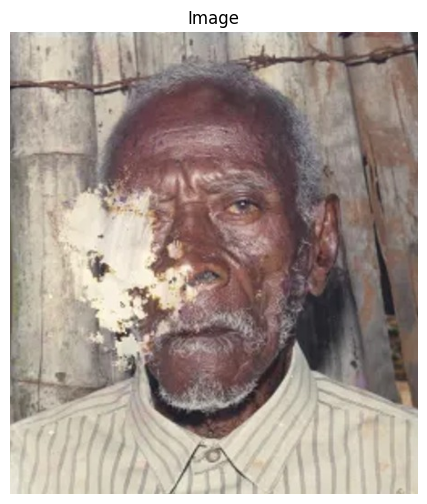

42 233 140.14778719066368


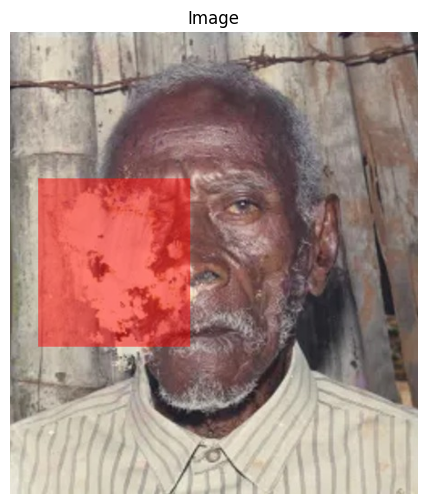

(448, 508) (448, 508)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

  0%|          | 0/47 [00:00<?, ?it/s]

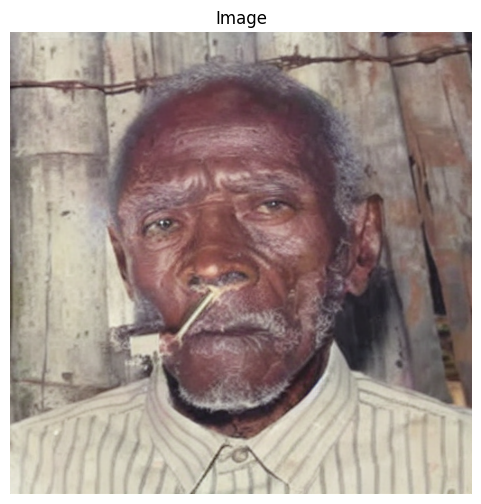

In [ ]:
import cv2
import numpy as np

def detectar_manchas(img,blur_small=3, blur_large=51, thresh_val=30, delta=40):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)

    fundo = cv2.GaussianBlur(gray, (51, 51), 0)

    print(np.min(fundo), np.max(fundo), np.mean(fundo))

    # Suaviza pequenas texturas
    blur_small_img = cv2.GaussianBlur(gray, (blur_small, blur_small), 0)

    # show_image(blur_small_img)

    # Estima o fundo com desfoque grande
    fundo = cv2.GaussianBlur(blur_small_img, (blur_large, blur_large), 0)



    # show_image(fundo)

    # Diferença entre imagem e fundo para realçar manchas claras
    diff = cv2.subtract(fundo, blur_small_img)

    # show_image(diff)

    # Inverte para pegar áreas mais claras
    diff = cv2.multiply(diff, -1)

    # Threshold para criar máscara
    thresh_val = np.mean(fundo) + delta
    if thresh_val > 255:
        thresh_val = 255  # limitar máximo
    _, mascara = cv2.threshold(fundo, thresh_val, 255, cv2.THRESH_BINARY)

    # show_image(mascara)

    # Limpeza de ruído
    kernel = np.ones((3,3), np.uint8)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel)

    return Image.fromarray(mascara.astype("uint8")).convert("L")


def process_mask(mask):
    mask_np = np.array(mask.convert("L"))
    _, mask_bin = cv2.threshold(mask_np, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return mask
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    rect_mask = np.zeros_like(mask_bin)
    rect_mask[y:y+h, x:x+w] = 255
    return Image.fromarray(rect_mask)

image = upload_image()

show_image(image)

mask = detectar_manchas(image, delta=60)


mask =  dilate_mask(mask, kernel_size=25, iterations=2)

mask = process_mask(mask)

# show_image(mask)
# show_image(process_mask(mask))

overlay = overlay_mask(image, mask, color=(255,0,0), alpha=0.5)

show_image(overlay)

print(image.size, mask.size)

pipe = load_model()

refined_image = refine_image(
    pipe=pipe,
    image=image,
    mask=mask,
    prompt="realistic human face, same person, maintain original skin tone, preserve facial features and ethnic characteristics, reconstruct eye and nose naturally, photorealistic, symmetric, detailed iris, natural lighting",
    negative="white spots, background artifacts, blurry, distorted",
    strength=0.94,
    guidance=10
)

show_image(refined_image)

# Rachaduras

Saving a355db95aecf9f9f05f6b3dcdbc92c53.jpg to a355db95aecf9f9f05f6b3dcdbc92c53.jpg


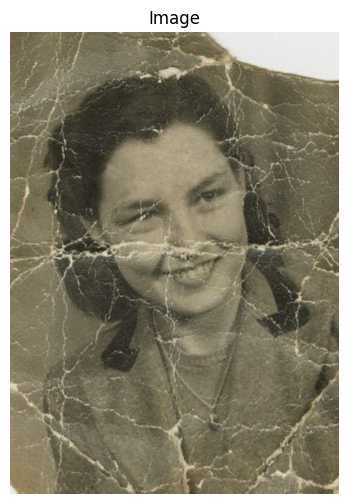

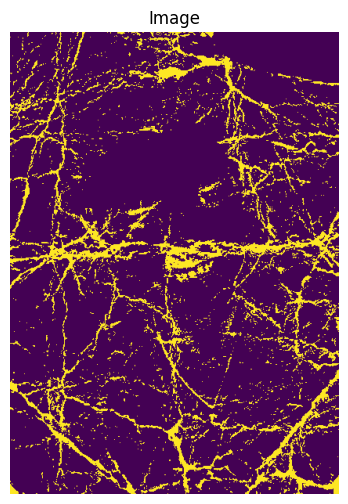

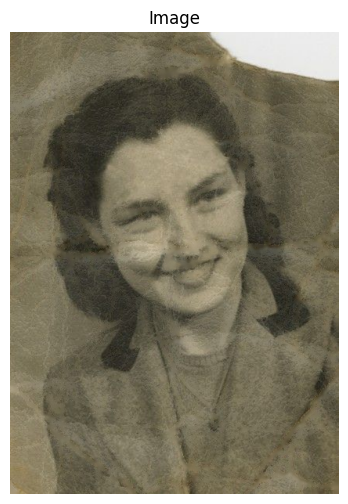

In [6]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
from PIL import Image


import numpy as np
import cv2
from PIL import Image

def detect_cracks(pil_img, kernel_size=15, threshold_factor=0.9):
    img = np.array(pil_img.convert("L"))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

    tophat_norm = cv2.normalize(tophat, None, 0, 255, cv2.NORM_MINMAX)

    otsu_thresh, _ = cv2.threshold(
        tophat_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    final_thresh = int(otsu_thresh * threshold_factor)

    _, binary = cv2.threshold(tophat_norm, final_thresh, 255, cv2.THRESH_BINARY)

    return binary



def thicken_mask(mask, thickness=3):
    mask = (mask > 0).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (thickness, thickness))
    return cv2.dilate(mask, kernel, iterations=1)


image = upload_image()
mask = detect_cracks(image)
# mask = thicken_mask(mask, 2)

show_image(image)
show_image(mask)

restored = cv2.inpaint( np.array(image.convert("RGB")).astype(np.uint8), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
# restored = cv2.inpaint( np.array(image.convert("RGB")).astype(np.uint8), mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)


# pipe = load_model()

# refined_image = refine_image(
#     pipe=pipe,
#     image=image,
#     mask=mask,
#     prompt="Fill the masked areas using the surrounding textures and colors, blending seamlessly",
#     negative="",
#     strength=0.9,
#     guidance=10
# )

show_image(restored)


# Pipeline

Saving 9e379e31-5b60-42f9-a435-83b6aecb4ea1.jfif to 9e379e31-5b60-42f9-a435-83b6aecb4ea1.jfif
grass
meadow completely covered by colorful flowers


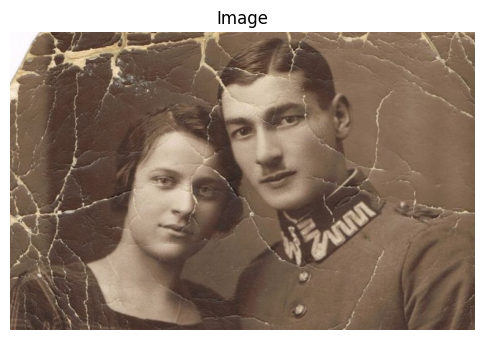

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

0


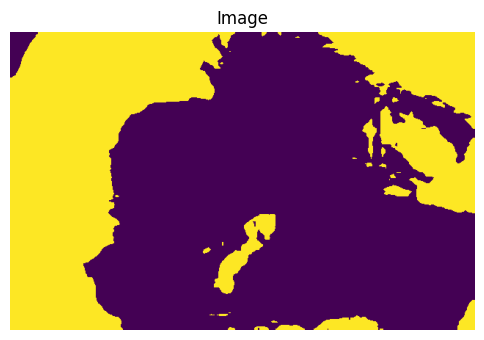

2


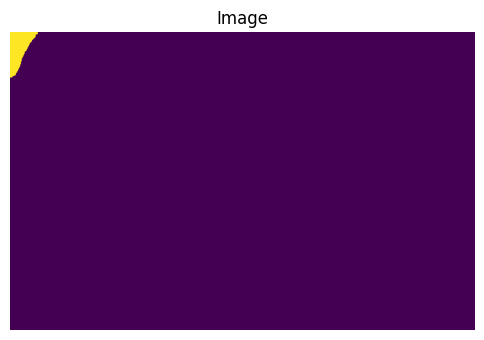

12


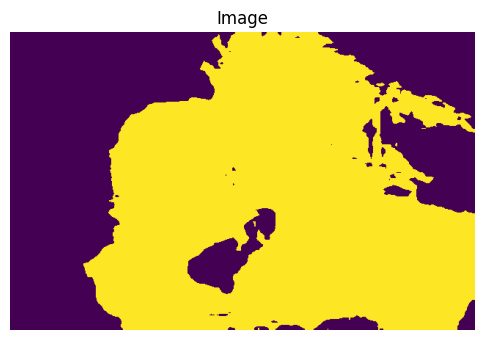

22


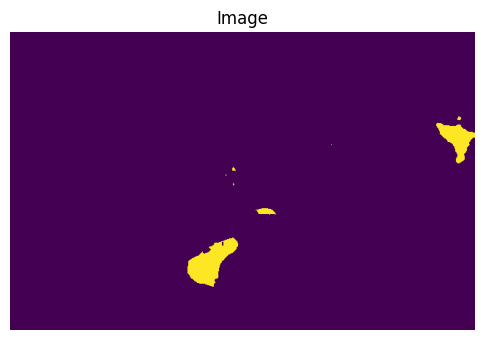

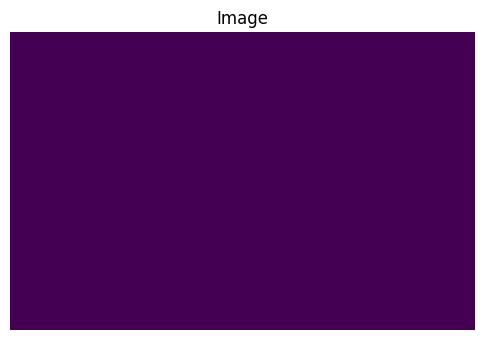

In [ ]:
DISPLAY_IMAGES = True

image = upload_image()

prompt = "replace the grass with meadow completely covered by colorful flowers"

source, target = extract_target_result(prompt)

print(source)
print(target)

if DISPLAY_IMAGES:
  show_image(image)

# 1. obtém máscara com modelo de segemntação
classes = get_classes()

segmentation_class = extract_class_from_prompt(prompt, classes)

feature_extractor, model = load_segmentation_model()

class_masks = get_masks(image, feature_extractor, model)

for key in class_masks:
  if np.any(class_masks[key]):
    print(key)
    show_image(Image.fromarray(class_masks[key]))

mask = get_mask_for_class_idx(class_masks, segmentation_class)

if DISPLAY_IMAGES:
  show_image(mask)

# 2. textual refinement

# pipe = load_model()

# refined_image = refine_image(
#     pipe=pipe,
#     image=image,
#     mask=mask,
#     prompt=target,
#     negative="",
#     strength=0.75,
#     guidance=13
# )

# if DISPLAY_IMAGES:
#   show_image(refined_image)